## About

Jupyter notebook on Text2Image prepared specifically for LLM 2024 class at University of Washington, Seattle.

In this notebook, we go through the following:

a) Set up for diffusion API

b) Use of diffusion API for image generation

c) Playing with different settings for Stable Diffusion

This is part of LLM Lecture series 2024 at University of Washington, Seattle (https://bytesizeml.github.io/llm2024/).

### 1. Setup

In [ ]:
! pip install -U transformers
! pip install datasets evaluate -q
! pip install jiwer -q
! pip install -U accelerate

In [1]:
# 1. Install Libraries
!pip3 install openai
!pip3 install python-dotenv


# 2. Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

import os
print(os.system('ls'))

os.chdir(os.curdir + "/drive/MyDrive/Colab_Notebooks_LLM_2023")

# 3. Open AI API Access Setup
import openai
import os

open_ai_key_file = "openai_api_key_llm_2023.txt" # Your OPEN AI Key in this file
with open(open_ai_key_file, "r") as f:
  for line in f:
    OPENAI_KEY = line
    break

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())



# 4. Open AI text generation APIs
from openai import OpenAI
client = OpenAI(api_key=OPENAI_KEY)
def get_completion_instruct(prompt, model="gpt-3.5-turbo-instruct"):
    response = client.completions.create(
        model=model,
        prompt=prompt
    )
    #return response.choices[0].text
    return response.choices[0].text

def get_completion(prompt, model="gpt-3.5-turbo"):
  message = {"role": "user", "content": prompt}
  response = client.chat.completions.create(
      model=model,
      messages=[message]
  )
  return response.choices[0].message.content

Mounted at /content/drive/
0


In [4]:
!pwd

/content/drive/MyDrive/Colab_Notebooks_LLM_2023


## 2. Stability AI demo

In [5]:
## Generates Token and use from hugging face
from huggingface_hub import notebook_login
notebook_login()

In [1]:
!pip install diffusers==0.8.0
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"
!wget https://raw.githubusercontent.com/huggingface/diffusers/4674fdf807cdefd4db1758067c0207872d805f8c/examples/inference/image_to_image.py
!pip install wget

--2024-02-27 21:18:49--  https://raw.githubusercontent.com/huggingface/diffusers/4674fdf807cdefd4db1758067c0207872d805f8c/examples/inference/image_to_image.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6808 (6.6K) [text/plain]
Saving to: ‘image_to_image.py’

image_to_image.py   100%[===================>]   6.65K  --.-KB/s    in 0s      

2024-02-27 21:18:49 (105 MB/s) - ‘image_to_image.py’ saved [6808/6808]



In [7]:
from google.colab import output
from pathlib import Path
from PIL import Image
import torch
from diffusers import StableDiffusionPipeline
import requests
import getpass
from io import BytesIO
#from image_to_image import StableDiffusionImg2ImgPipeline, preprocess
import os, wget

output.enable_custom_widget_manager()
cache_drive = False

### 2a. Text 2 Image Synthesis

In [20]:
# Helping function for plotting images in a 2D grid
from PIL import Image
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [9]:
!ls

## 2b. Load Model

In [93]:
from huggingface_hub import notebook_login
notebook_login()

import torch
from diffusers import StableDiffusionPipeline

device = "cuda"
model_id = "CompVis/stable-diffusion-v1-4"

pipe_txt2image = StableDiffusionPipeline.from_pretrained(
    model_id,
    revision="fp16",
    torch_dtype=torch.float16,
).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## 2c. Model *Inference*

  0%|          | 0/51 [00:00<?, ?it/s]

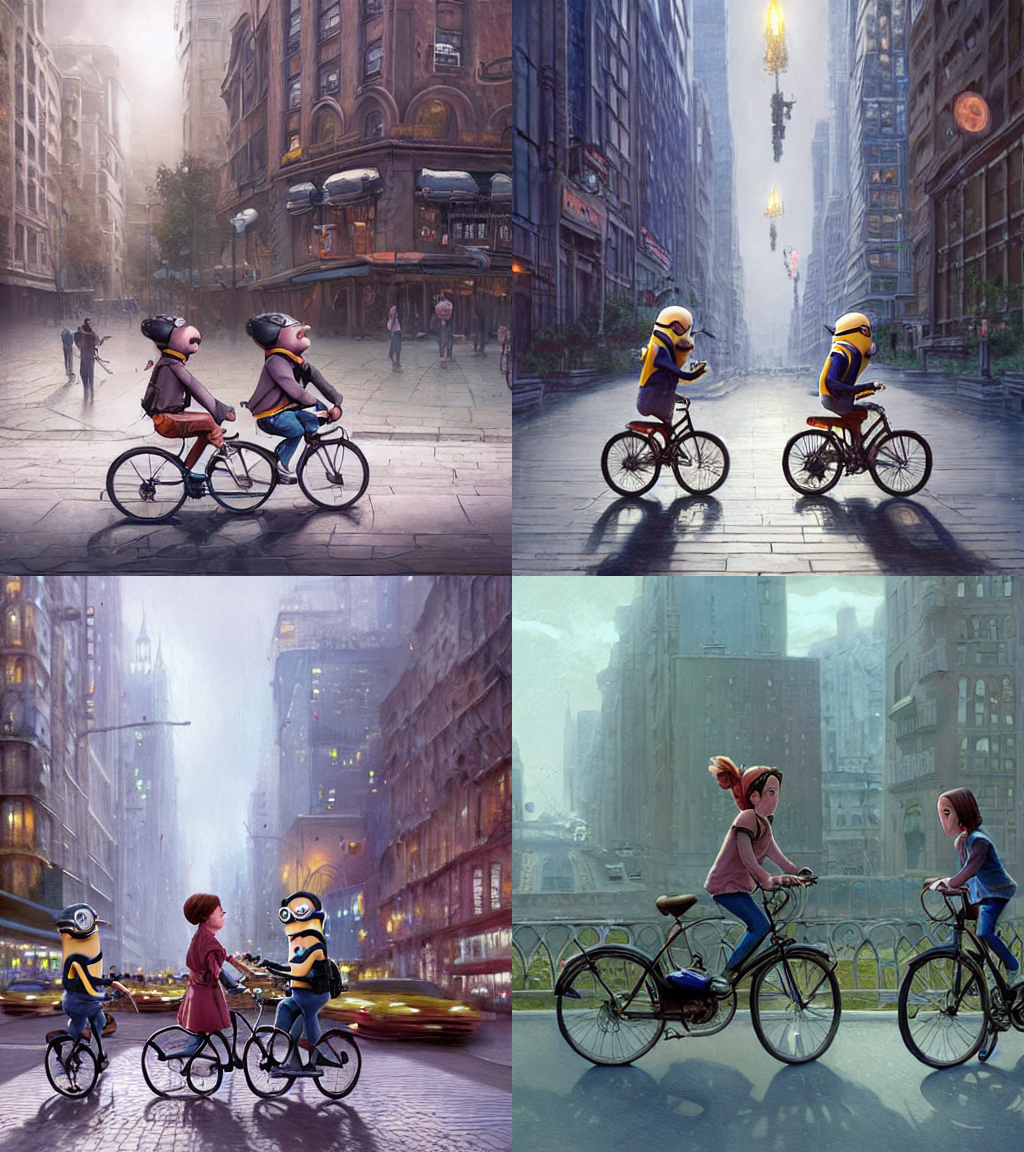

In [94]:
#@title ### 2c. Stable Diffusion txt2img
prompt = "Two minions riding a bicycle in the city, with the Guru, tone mapped, shiny, intricate, cinematic lighting, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by terry moore and greg rutkowski" #@param {type:"string"}

#@markdown Height of the Image:
H = 576 #@param {type:"slider", min:256, max:1024, step:64}

#@markdown Width of the Image:
W = 512 #@param {type:"slider", min:256, max:1024, step:64}

#@markdown Number of images to generate:
n = 4 #@param {type:"integer"}

#@markdown Seed:
seed = 3 #@param {type:"integer"}

#@markdown Steps to generate the image(lower number->faster but crappier image):
steps = 50 #@param {type:"slider", min:1, max:150, step:1}

#@markdown How strong your text prompt should influence the image(default 7.5)
guidance_scale = 7.5 #@param {type:"slider", min:6, max:15, step:0.1}

#@markdown ### Display Settings
show_grid = True #@param {type:"boolean"}
#@markdown If you have `show_grid` enabled, make sure `n = rows*columns`
#@markdown , Ignore if you have `show_grid` disabled.

prompt = [prompt] * n
generator = torch.Generator("cuda").manual_seed(seed)
with torch.autocast("cuda"):
    images = pipe_txt2image(prompt, num_inference_steps=steps, height=H, width=W, guidance_scale=guidance_scale)["images"]
    print("length of images = ", len(images))
    del generator

if show_grid:
    rows = 2 #@param {type:"integer"}
    columns = 2 #@param {type:"integer"}

    grid = image_grid(images, rows=rows, cols=columns)
    display(grid)

## 2d. Image 2 Image Synthesis

In [66]:
import os
import wget
def download_sample_images(num_imgs):
  for i in range(0,num_imgs):
    filename = f"{i}.jpg"
    if os.path.exists(filename):
      os.remove(filename)
    wget.download("https://picsum.photos/384",out=filename)

num_imgs = 4
download_sample_images(num_imgs)

In [67]:
from PIL import Image
from matplotlib import pyplot as plt

# Load images from disk and display them
def load_images(img_dir,num_imgs):
  imgs = []
  fig,axes = plt.subplots(1,num_imgs,figsize=(20,10))
  for i in range(0,num_imgs):
    img = Image.open(img_dir+f'{i}.jpg')
    imgs.append(img)
    axes[i].imshow(img)
    axes[i].set_axis_off()
  fig.tight_layout()
  return imgs

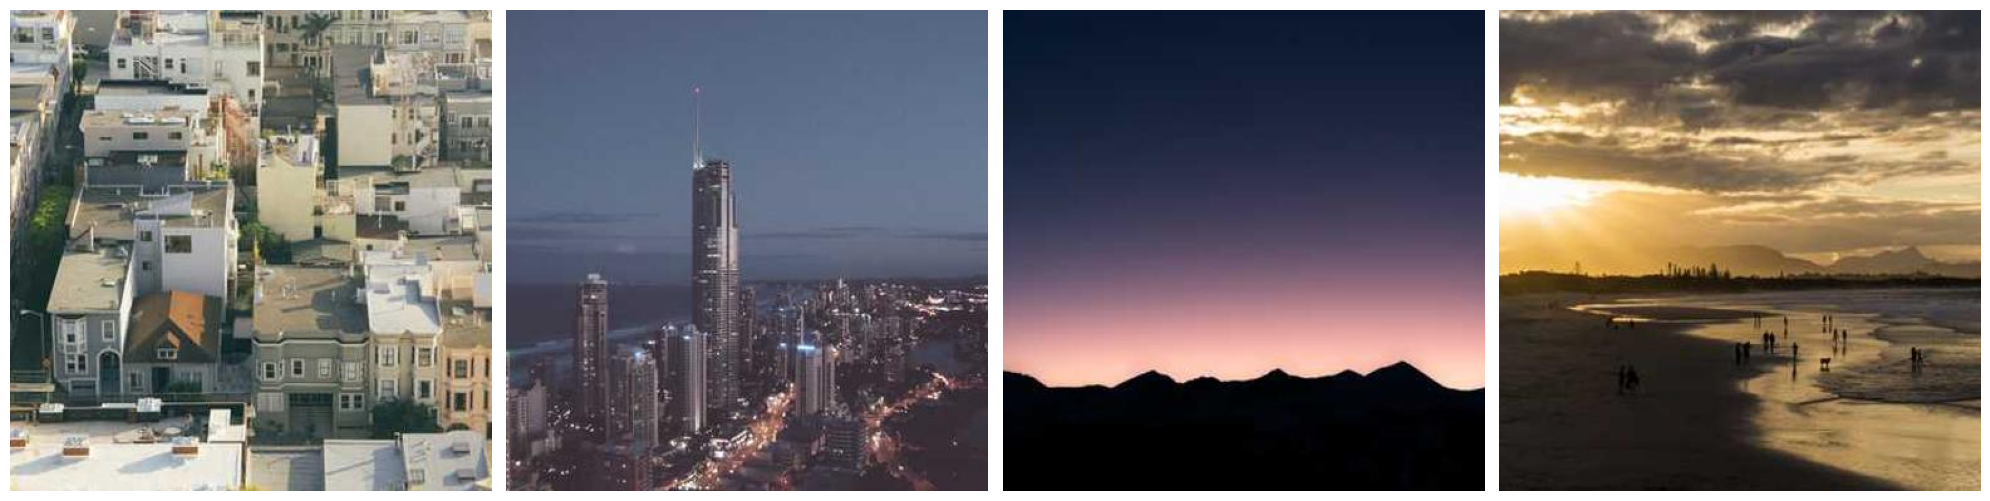

In [68]:
imgs = load_images("./",num_imgs)

In [76]:
captions = ["" for i in range(4)]
#@title ### Add a Caption for each image above in the following textboxes
captions[0] = "A pair of white female shoes lying on the floor" #@param {type:"string"}
captions[1] = "Multiple paintings are hanging on the wall" #@param {type:"string"}
captions[2] = "A lake with a snowy mountain in the background" #@param {type:"string"}
captions[3] = "Minions bouncing aronud" #@param {type:"string"}

In [58]:
from diffusers import StableDiffusionImg2ImgPipeline
device = "cuda"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)


Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

In [59]:
import PIL
from PIL import Image
def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

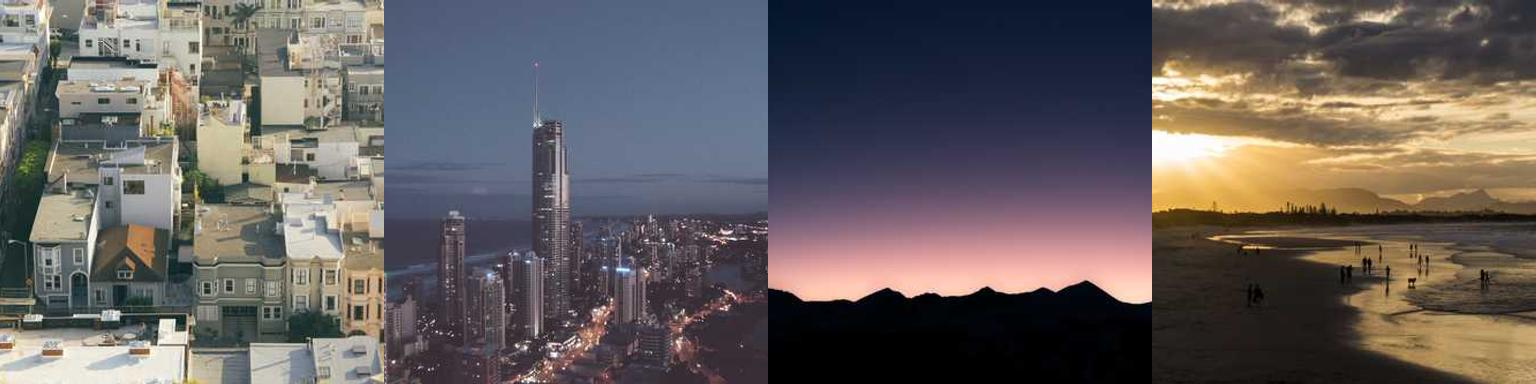

  0%|          | 0/49 [00:00<?, ?it/s]

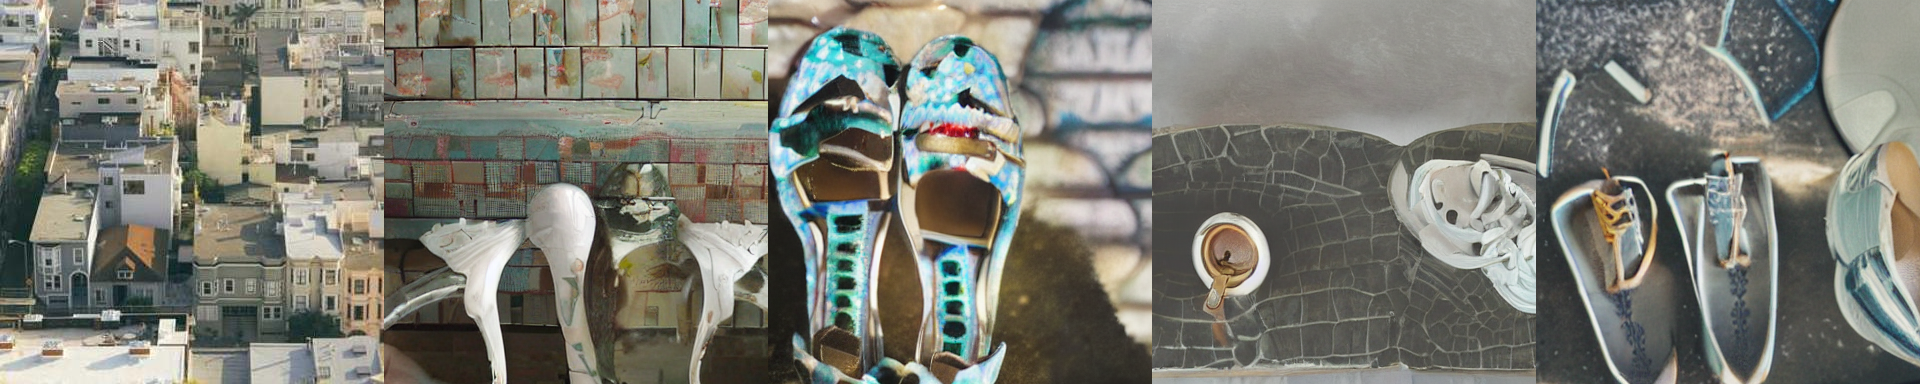

  0%|          | 0/49 [00:00<?, ?it/s]

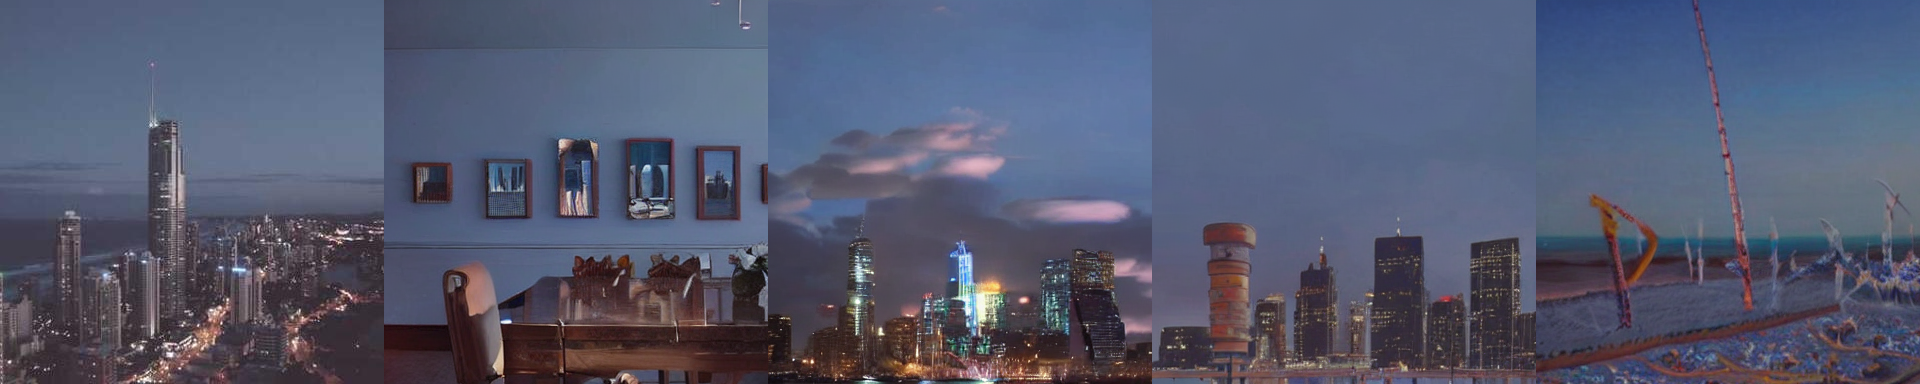

  0%|          | 0/49 [00:00<?, ?it/s]

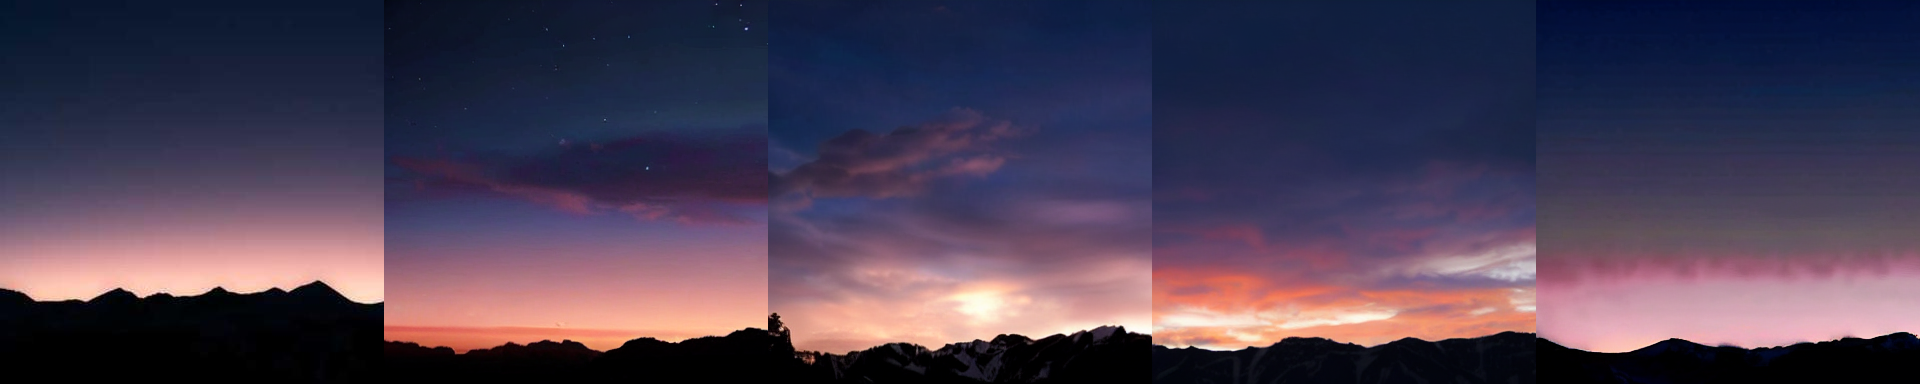

  0%|          | 0/49 [00:00<?, ?it/s]

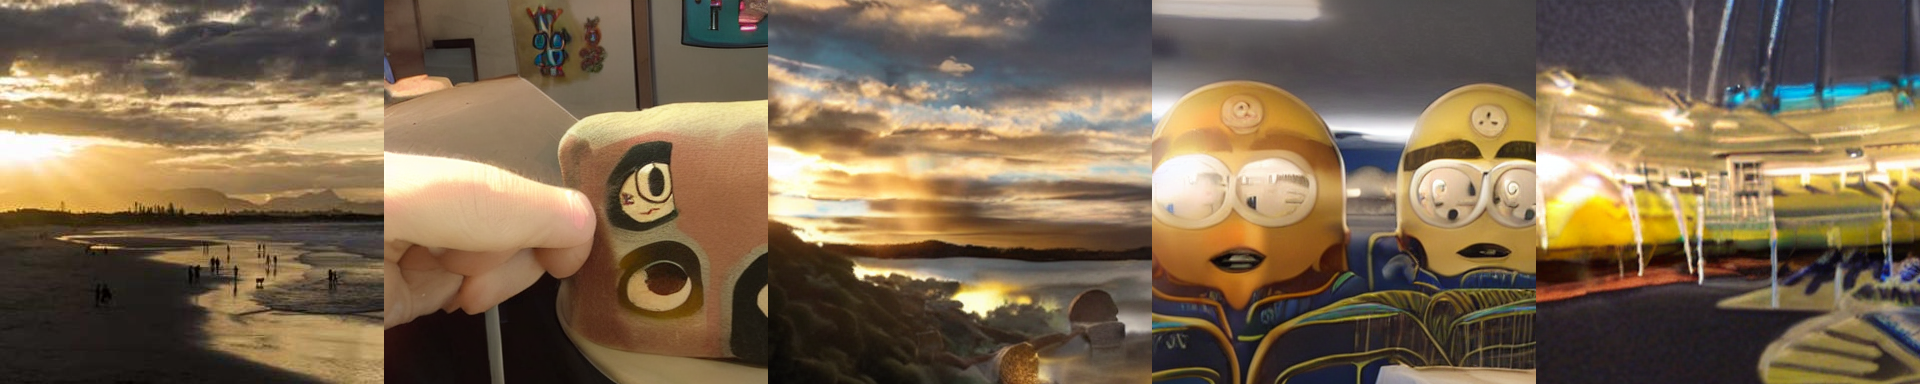

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [91]:
import numpy as np
from matplotlib import pyplot as plt

H = 450
W = 450

#@markdown Seed:
seed = 1 #@param {type:"integer"}

#@markdown Steps to generate the image(lower number->faster but crappier image):
steps = 60 #@param {type:"slider", min:1, max:150, step:1}

#@markdown How strong your text prompt should influence the image(default 7.5)
guidance_scale = 0 #@param {type:"slider", min:6, max:15, step:0.1}

print(captions)
#plt.figure()
#grid = image_grid(imgs,rows=1,cols=len(imgs))  #Show three images for each original image
#display(grid)
plt.figure()

for i in range(len(imgs)):
  #input_image = Image.open(path_to_input_image).convert("RGB")
  img = imgs[i]
  input_image = img.resize((W, H))
  input_image_array = preprocess(input_image)

  generator = torch.Generator("cuda").manual_seed(seed)
  with torch.autocast("cuda"):
      prompt = [captions[i]]*num_imgs
      images = pipe(prompt, init_image=input_image_array, num_inference_steps=steps, generator=generator, guidance_scale=guidance_scale)["images"]
      del generator

  #@markdown ### Display Settings
  show_grid = True #@param {type:"boolean"}
  if show_grid:
      #new_grid = [input_image, images[0]]
      images.insert(0,imgs[i])
      grid = image_grid(images,rows=1,cols=len(imgs)+1)  #Show three images for each original image
      display(grid)
  else:
      display(images[0])

## ICE 1

Play around with the image data set above and:

a) Test the image generation for a really small steps vs large steps - What difference do you notice?
b) Test the image generation with a high guidance scale vs a low guidane scale - What do you notice?

In [95]:
## YOUR CODE HERE


## ICE 2

Imagine now that you want to use the starter image as a background and generate an image corrposnding to each caption with the background as a starter iamge.

For example: For the 4th image above - Generate minions with the background of the ocean and mountains.

How would your use of Stability APIs change? What would be a creative prompt that can get the job done here?

In [97]:
## YOUR CODE HERE

## Display the generated images

## ICE 3 Text2Video!
Pick an interesting body of text that's imaginative and descriptive - Like from an adventurous novel or short stories. Pick a few pages - Use the APIs above to generate multiple images per sentence, so you get multiple frames per sentence. Concatenate all the images in a way that you can convert it into a video. How would you smoothen the video for continuity, smoothness and alignment with the text?